## Importing Python Packages

In [1]:
import os
import pathlib
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm.autonotebook import tqdm;

plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

/tmp/ipykernel_851967/1862305781.py:17: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm;


In [2]:
# seed = 17
# torch.manual_seed(seed);
# random.seed(seed)
# np.random.seed(seed)
torch.use_deterministic_algorithms(False)
# torch.set_default_tensor_type(torch.DoubleTensor)
torch.backends.cudnn.benchmark = False

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0);

In [4]:
tag = 'ModelP-Scheduled'

## RadarPCL Model

In [5]:
class RadarPCL(nn.Module):
    
    def __init__(self,seq_len=4):
        super(RadarPCL, self).__init__()
        self.seq_len = seq_len
        self.conv_lateral = nn.Sequential(
            self._conv(2, 128, 7, 1, 0, 4, 1),
            self._conv(128, 128, 7, 1, 0, 4, 1),
            self._conv(128, 128, 7, 1, 0, 4, 1),
            self._conv(128, 128, 7, 1, 0, 4, 1),
        )
        self.linear_lateral = nn.Sequential(
            nn.Linear(4*4*128, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 4, bias=False),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 1, bias=False),
            nn.BatchNorm1d(1),
            nn.GELU(),
        )
        
    def _conv(self, in_channel, out_channel, kernel_size, stride, padding, dilation, groups):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.GELU()
        )
    
    def forward(self, I_lateral):
        batch_size = I_lateral.size(0)
        # Lateral-View
        x_lateral = self.conv_lateral(I_lateral)
        x_lateral = x_lateral.view(batch_size, -1)
        x_lateral = self.linear_lateral(x_lateral)
        # Adding speed components
        x = x_lateral
        return x

In [6]:
seq_len = 1

In [7]:
model = RadarPCL(seq_len=seq_len)

In [8]:
summary(model, input_size=[(1, 2, 100, 100)])

/home/20prmd/Documents/IROS2023/env/lib/python3.8/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/20prmd/Documents/IROS2023/env/lib/python3.8/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RadarPCL                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 4, 4]            --
│    └─Sequential: 2-1                   [1, 128, 76, 76]          --
│    │    └─Conv2d: 3-1                  [1, 128, 76, 76]          12,544
│    │    └─BatchNorm2d: 3-2             [1, 128, 76, 76]          256
│    │    └─GELU: 3-3                    [1, 128, 76, 76]          --
│    └─Sequential: 2-2                   [1, 128, 52, 52]          --
│    │    └─Conv2d: 3-4                  [1, 128, 52, 52]          802,816
│    │    └─BatchNorm2d: 3-5             [1, 128, 52, 52]          256
│    │    └─GELU: 3-6                    [1, 128, 52, 52]          --
│    └─Sequential: 2-3                   [1, 128, 28, 28]          --
│    │    └─Conv2d: 3-7                  [1, 128, 28, 28]          802,816
│    │    └─BatchNorm2d: 3-8             [1, 128, 28, 28]          25

## Dataset Class

In [9]:
class RadarDataset(Dataset):
    
    def __init__(self, path, seq_len=1, px=150, py=150, pz=150, rx=19.3*2, ry=19.3, rz=10., dAzi=15., dElev=15., dRoll=15., augment=True, transform=None):
        super(RadarDataset, self).__init__()
        
        self.path = path
        self.seq_len = seq_len
        self.px = px
        self.py = py
        self.pz = pz
        self.rx = rx
        self.ry = ry
        self.rz = rz
        self.dAzi = dAzi
        self.dElev = dElev
        self.dRoll = dRoll
        self.augment = augment
        self.transform = transform
        self.speeds = []
        self.timestamps = []
        
        _, _, files = next(os.walk(path))
        print(f'>>> Found {len(files)} files in the selected directory. Building dataset...')
        pbar = tqdm(total=len(files))
        
        self.offset_dict = {}
        self.length = 0
        pathlib.Path(self.path + 'Processed').mkdir(parents=True, exist_ok=True)
    
        # Creating unified file to optimize RAM
        with open(self.path + 'Processed/unified-seq.txt', 'w') as u:
            for file in files:
                with open(self.path + file, 'r') as f:
                    # Data is a list(timestamp, list(detections), speed)
                    data = f.read().splitlines()
                    for i in range(seq_len-1, len(data)):
                        group = []
                        status = []
                        for j in range(i, i - seq_len, -1):
                            # Evaluating current line
                            curr = eval(data[j])
                            group.append([curr[0],curr[1],curr[2]])
                            status.append(curr[3])
                        # Saving data in a unified file if it contains at least one valid scan
                        if status[0] > 0:
                            self.offset_dict[self.length] = u.tell()
                            u.write(str(group)+'\n')
                            first_group = group[0]
                            speed = first_group[-1]
                            timestamp = first_group[0]
                            self.speeds.append(speed)
                            self.timestamps.append(timestamp)
                            self.length += 1
                pbar.update(n=1)
            
        
    def __len__(self):
        return len(self.offset_dict)
    

    def __getitem__(self, id):
        # Reading data on demand
        offset = self.offset_dict[id]
        with open(self.path + 'Processed/unified-seq.txt', 'r', encoding='utf-8') as f:
            f.seek(offset)
            line = f.readline()
            # Processing recovered data
            group = eval(line)
            # Computing random angles to be used in the sequence
            dAzi = random.uniform(-self.dAzi,self.dAzi) * np.pi/180.
            dElev = random.uniform(-self.dElev,self.dElev) * np.pi/180.
            dRoll = random.uniform(-self.dRoll,self.dRoll) * np.pi/180.
            # Lists to store the sequence of data
            I_top_scans = []
            curr_speed = 0.
            curr_timestamp = 0.
            for i, (t, data, speed) in enumerate(group):
                data = np.array(data)
                # Augmenting data
                if self.augment:
                    data = self._rotate(data, dAzi, dElev, dRoll)
                # We normalize the position vector to get speed components
                n = data[:,:3] / np.expand_dims(np.linalg.norm(data[:,:3], axis=1), axis=1)
                speed_xyz = n * np.expand_dims(data[:,5],axis=1)
                # Preparing tensors
                I_top = self._top(np.copy(data), speed_xyz, px=self.px, py=self.py, rx=self.rx, ry=self.ry)
                I_top = torch.FloatTensor(I_top)
                I_top_scans.append(I_top)
                if i == 0:
                    curr_speed = speed
                    curr_timestamp = t
            I_top_scans = torch.cat(I_top_scans, dim=0)
            curr_speed = torch.FloatTensor([curr_speed])
            curr_timestamp = torch.DoubleTensor([curr_timestamp])
        return I_top_scans, curr_speed, curr_timestamp
    
    
    def _rotate(self, data, dAzi, dElev, dRoll):
        ''' data has columns in the following order: x, y, z, rcs, snr, speed '''
        # Rotating points
        Rz = np.array([[np.cos(dAzi), -np.sin(dAzi), 0.],
                       [np.sin(dAzi), np.cos(dAzi), 0.],
                       [0., 0., 1.]])
        Ry = np.array([[np.cos(dElev), 0., np.sin(dElev)],
                       [0., 1., 0.],
                       [-np.sin(dElev), 0., np.cos(dElev)]])
        Rx = np.array([[1., 0., 0.],
                       [0., np.cos(dRoll), -np.sin(dRoll)],
                       [0., np.sin(dRoll), np.cos(dRoll)]])
        R = Rz @ Ry @ Rx
        pts = data[:,:3].T
        pts = R.dot(pts).T
        data[:,:3] = pts
        return data
        
    
    def _top(self, P, speed_xyz, px, py, rx, ry):
        ''' P has columns in the following order: x, y, z, rcs, snr, speed '''
        # Adjusting coordinates from radar to image
        P[:, [0,1]] = P[:, [1,0]]
        P[:, 0] *= -1
        I = np.zeros((2,py,px), dtype=np.float64)
        T = np.zeros((P.shape[0],2), dtype=np.uint16)
        # Computing mapped positions
        T[:,1] = np.uint16(np.maximum(np.minimum((px/rx) * P[:,0] + (px/2), px-1), 0))    
        T[:,0] = np.uint16(np.maximum(np.minimum((py/ry) * P[:,1], py-1), 0))
        # Mapping the space to the first layer
        # I[0,T[:,0],T[:,1]] = np.squeeze(P[:,2])
        # Mapping the rcs to the second layer
        # I[1,T[:,0],T[:,1]] = np.squeeze(P[:,3])
        # Mapping the snr to the second layer
        I[0,T[:,0],T[:,1]] = np.squeeze(P[:,4])
        # Mapping the speed to the forth layer
        # In the top view, speed is composed by x and y
        I[1,T[:,0],T[:,1]] = np.squeeze(speed_xyz[:,0])
        return I

## Functions

In [10]:
def hist(data, bins=6, res=2):
    n = [0]*bins
    for x in data:
        bin_id = int(x//res)
        n[bin_id] += 1
    centres = [i*res + res/2 for i in range(bins)]
    n = [i/sum(n)*100 for i in n]
    fig, ax = plt.subplots(figsize=[5,2.5])
    ax.grid(linestyle=':')
    bars = ax.bar(centres, n, res, color='b', edgecolor='black')
    heights = []
    # for i, bar in enumerate(bars):
    #     yval = bar.get_height()
    #     heights.append(yval)
    #     ax.text(centres[i]-1.5, yval + 1, "{:0.2f}\%".format(yval))
    ax.set_xlabel("Speed [$m/s$]")
    ax.set_ylabel("\%")
    ax.set_xticks(range(0,bins*res,res))
    ax.set_xlim(right=bins*res-res/2)
    ax.set_axisbelow(True)
    plt.show()

In [11]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    for I_top, speed, _ in dataloader:
        I_top = I_top.to(device=device)
        speed = speed.to(device=device)
        y = model(I_top)
        loss = loss_fn(speed, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [12]:
def test_epoch(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for I_top, speed, _ in dataloader:
            I_top = I_top.to(device=device)
            speed = speed.to(device=device)
            y = model(I_top)
            loss = loss_fn(speed, y)
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)

In [13]:
def valid_epoch(model, dataloader, loss_fn, device):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for I_top, speed, _ in dataloader:
            I_top = I_top.to(device=device)
            speed = speed.to(device=device)
            y = model(I_top)
            loss = loss_fn(speed, y)
            valid_loss += loss.item()
    return valid_loss / len(dataloader.dataset)

In [14]:
def preview(model, dataloader, device, path, epoch, lr, show=False, save=False):
    model.eval()
    ref = []
    est = []
    timestamps = []
    inference = []
    with torch.no_grad():
        for I_top, speed, t in dataloader:
            speed = speed.to(device=device)
            t = t.to(device=device)
            tic = time.time()
            I_top = I_top.to(device=device)
            y = model(I_top)
            toc = time.time()
            inference.append(toc-tic)
            ref.append(speed.cpu().numpy()[0][0])
            est.append(y.cpu().numpy()[0][0])
            timestamps.append(t.cpu().numpy()[0][0])
    fig, ax = plt.subplots(figsize=[12.8, 4.8])
    ax.plot(est, 'r', linewidth=0.5, label='$\hat{\mathbf{x}}$')
    ax.plot(ref, 'b', linewidth=0.75, label='$\mathbf{x}$')
    ax.set_xlabel('Samples')
    ax.set_ylabel('m/s')
    ax.legend(loc='upper left', fancybox=False)
    ax.text(0, 1, f'LR = {lr}',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    plt.savefig(path + 'epoch_' + str(epoch).rjust(4, '0') + '.png')
    if show:
        plt.show()
    plt.close(fig)    
    if save:
        timestamps = np.array(timestamps).reshape((-1,1))
        ref = np.array(ref).reshape((-1,1))
        est = np.array(est).reshape((-1,1))
        df = pd.DataFrame(np.hstack((timestamps,ref,est)), columns=['Time','ref','est'])
        df.to_csv(os.path.join(path, 'processed.csv'), index=False)
        print(f'Inference time [ms]: {np.array(inference).mean()*1e3}')
    return None

## Preparing Datasets and Dataloaders

In [15]:
# t = transforms.Compose([transforms.ToTensor()])

In [16]:
px = 100
py = 100
pz = 100
rx = 20. * 2
ry = 20.
rz = 15.
dAzi = 15.
dElev = 15.
dRoll = 15.

In [17]:
train_data = RadarDataset('synched_fr_modelP/train/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, dAzi=dAzi, dElev=dElev, dRoll=dRoll, augment=True)

>>> Found 10 files in the selected directory. Building dataset...


100%|███████████████████████████████████████████| 10/10 [01:50<00:00, 11.09s/it]


In [18]:
len(train_data)

176336

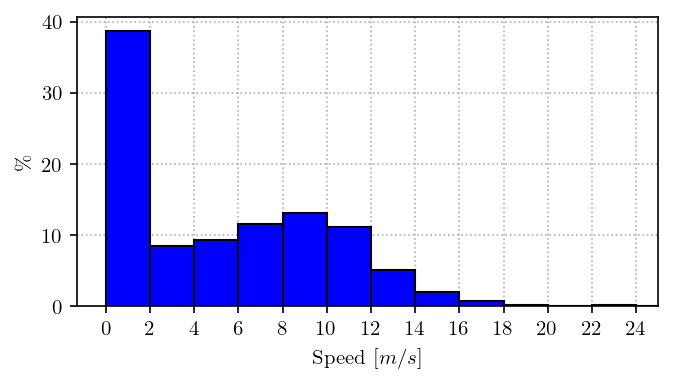

In [19]:
hist(train_data.speeds, bins=13, res=2)

In [20]:
test_data = RadarDataset('synched_fr_modelP/test/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, augment=False)

>>> Found 1 files in the selected directory. Building dataset...


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


In [21]:
len(test_data)

24960

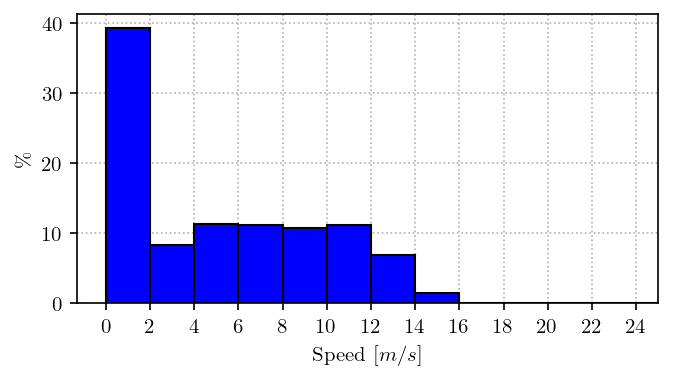

In [22]:
hist(test_data.speeds, bins=13, res=2)

In [23]:
valid_data = RadarDataset('synched_fr_modelP/valid/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, augment=False)

>>> Found 1 files in the selected directory. Building dataset...


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]


In [24]:
len(valid_data)

15303

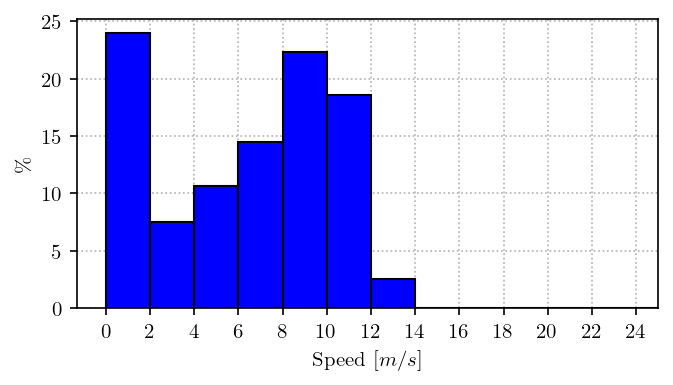

In [25]:
hist(valid_data.speeds, bins=13, res=2)

In [26]:
train_loader = DataLoader(train_data, batch_size=512, drop_last=True, shuffle=True, pin_memory=True, num_workers=16, worker_init_fn=seed_worker, generator=g)

In [27]:
test_loader = DataLoader(test_data, batch_size=512, drop_last=True, shuffle=True, pin_memory=True, num_workers=16, worker_init_fn=seed_worker, generator=g)

In [28]:
valid_loader = DataLoader(valid_data, batch_size=512, drop_last=True, shuffle=True, pin_memory=True, num_workers=16, worker_init_fn=seed_worker, generator=g)

In [29]:
preview_loader = DataLoader(test_data, batch_size=1, drop_last=False, shuffle=False, pin_memory=True, num_workers=4, worker_init_fn=seed_worker, generator=g)

## Training model

In [30]:
model = RadarPCL(seq_len)

Loading weights

In [31]:
# target = '2023-02-16-06-28-39-RadarNet-V5'

In [32]:
# pretrained = torch.load('checkpoints/' + target + '/weights.pt')
# pretrained.keys()

In [33]:
# model.load_state_dict(pretrained['model_state_dict'])

In [34]:
# optimizer.load_state_dict(pretrained['optimizer_state_dict'])

In [35]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [36]:
model.to(device);

In [37]:
loss_fn = nn.MSELoss()

In [38]:
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [39]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20)

Running the training routine

In [40]:
epochs = 100

In [41]:
best_loss = np.inf

In [42]:
train_losses = []
test_losses  = []
valid_losses  = []

In [43]:
pathlib.Path('checkpoints/' + tag).mkdir(parents=True, exist_ok=True)
pathlib.Path('checkpoints/' + tag + '/Images').mkdir(parents=True, exist_ok=True)

In [44]:
init = time.time()
for epoch in range(epochs):
    # Training model
    tic = time.time()
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    test_loss  = test_epoch(model, test_loader, loss_fn, device)
    valid_loss = valid_epoch(model, valid_loader, loss_fn, device)
    scheduler.step(test_loss)
    toc = time.time()
    print(f'EPOCH {epoch+1}/{epochs} \t TRAIN LOSS: {round(train_loss,6)} \t TEST LOSS: {round(test_loss,6)} \t VALID LOSS: {round(valid_loss,6)} \t TIME: {round((toc-tic)/60,3)}min')
    
    # Saving best weights
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save({
            'epoch':epoch,
            'test_loss':test_loss,
            'lr':scheduler.state_dict()["_last_lr"][0],
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()
        }, 'checkpoints/' + tag + '/' + 'weights.pt')
        
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    valid_losses.append(valid_loss)
    
    # Previewing test data
    if epoch % 10 == 0:
        path = 'checkpoints/' + tag + '/Images/'
        lr = scheduler.state_dict()["_last_lr"][0]
        preview(model, preview_loader, device, path, epoch, lr, show=False)

endd = time.time()
print(f'Total training time: {round((endd-init)/60,3)}min')

EPOCH 1/100 	 TRAIN LOSS: 0.079311 	 TEST LOSS: 0.070348 	 VALID LOSS: 0.08146 	 TIME: 2.224min
EPOCH 2/100 	 TRAIN LOSS: 0.072682 	 TEST LOSS: 0.061944 	 VALID LOSS: 0.070529 	 TIME: 2.203min
EPOCH 3/100 	 TRAIN LOSS: 0.066391 	 TEST LOSS: 0.059707 	 VALID LOSS: 0.069401 	 TIME: 2.205min
EPOCH 4/100 	 TRAIN LOSS: 0.059548 	 TEST LOSS: 0.048829 	 VALID LOSS: 0.056844 	 TIME: 2.202min
EPOCH 5/100 	 TRAIN LOSS: 0.052585 	 TEST LOSS: 0.044655 	 VALID LOSS: 0.051875 	 TIME: 2.202min
EPOCH 6/100 	 TRAIN LOSS: 0.045887 	 TEST LOSS: 0.03536 	 VALID LOSS: 0.041727 	 TIME: 2.195min
EPOCH 7/100 	 TRAIN LOSS: 0.039503 	 TEST LOSS: 0.031729 	 VALID LOSS: 0.036326 	 TIME: 2.2min
EPOCH 8/100 	 TRAIN LOSS: 0.03359 	 TEST LOSS: 0.027036 	 VALID LOSS: 0.03266 	 TIME: 2.193min
EPOCH 9/100 	 TRAIN LOSS: 0.028131 	 TEST LOSS: 0.02224 	 VALID LOSS: 0.025992 	 TIME: 2.198min
EPOCH 10/100 	 TRAIN LOSS: 0.023243 	 TEST LOSS: 0.019432 	 VALID LOSS: 0.021028 	 TIME: 2.201min
EPOCH 11/100 	 TRAIN LOSS: 0.018892 

In [45]:
torch.save({'train_losses':train_losses,
            'test_losses':test_losses,
            'valid_losses':valid_losses}, 'checkpoints/' + tag + '/' + 'losses.pt')

In [46]:
pretrained = torch.load('checkpoints/' + tag + '/weights.pt')
# pretrained.keys()+ '/weights.pt')
model.load_state_dict(pretrained['model_state_dict'])

<All keys matched successfully>

In [47]:
path = 'checkpoints/' + tag + '/'
preview(model,preview_loader,device,path,pretrained['epoch'],pretrained['lr'],show=False)

## Checking validation data

In [48]:
losses = torch.load('checkpoints/' + tag + '/losses.pt')

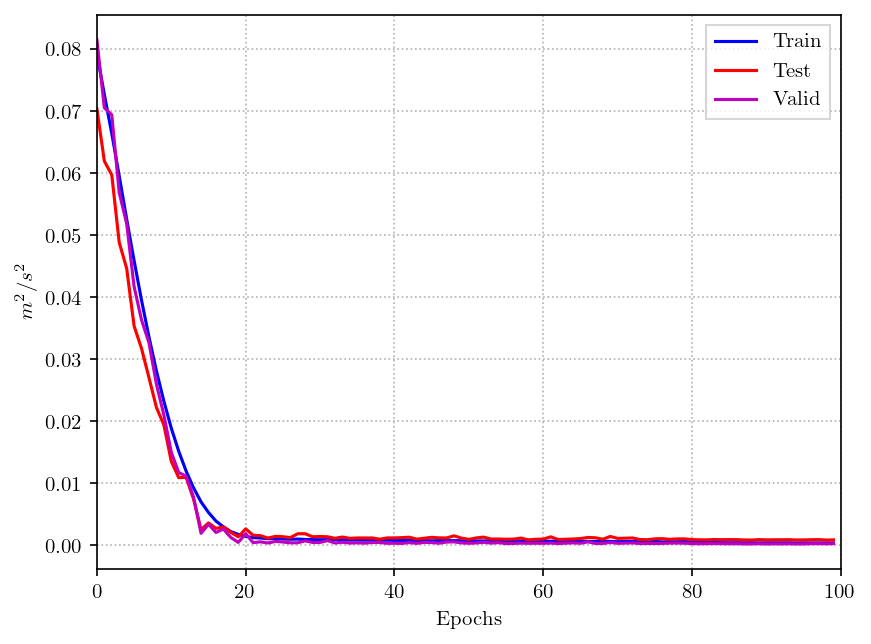

In [49]:
plt.plot(losses['train_losses'],'b',label='Train')
plt.plot(losses['test_losses'],'r',label='Test')
plt.plot(losses['valid_losses'],'m',label='Valid')
plt.legend(fancybox=False)
plt.xlabel('Epochs')
plt.ylabel('$m^2/s^2$')
plt.grid(linestyle=':')
# plt.ylim(top=0.05)
plt.xlim(left=0,right=100)
plt.savefig('checkpoints/' + tag + '/losses.png')
plt.show();

In [50]:
valid_loader = DataLoader(valid_data, batch_size=1, drop_last=False, shuffle=False, pin_memory=False, num_workers=0)

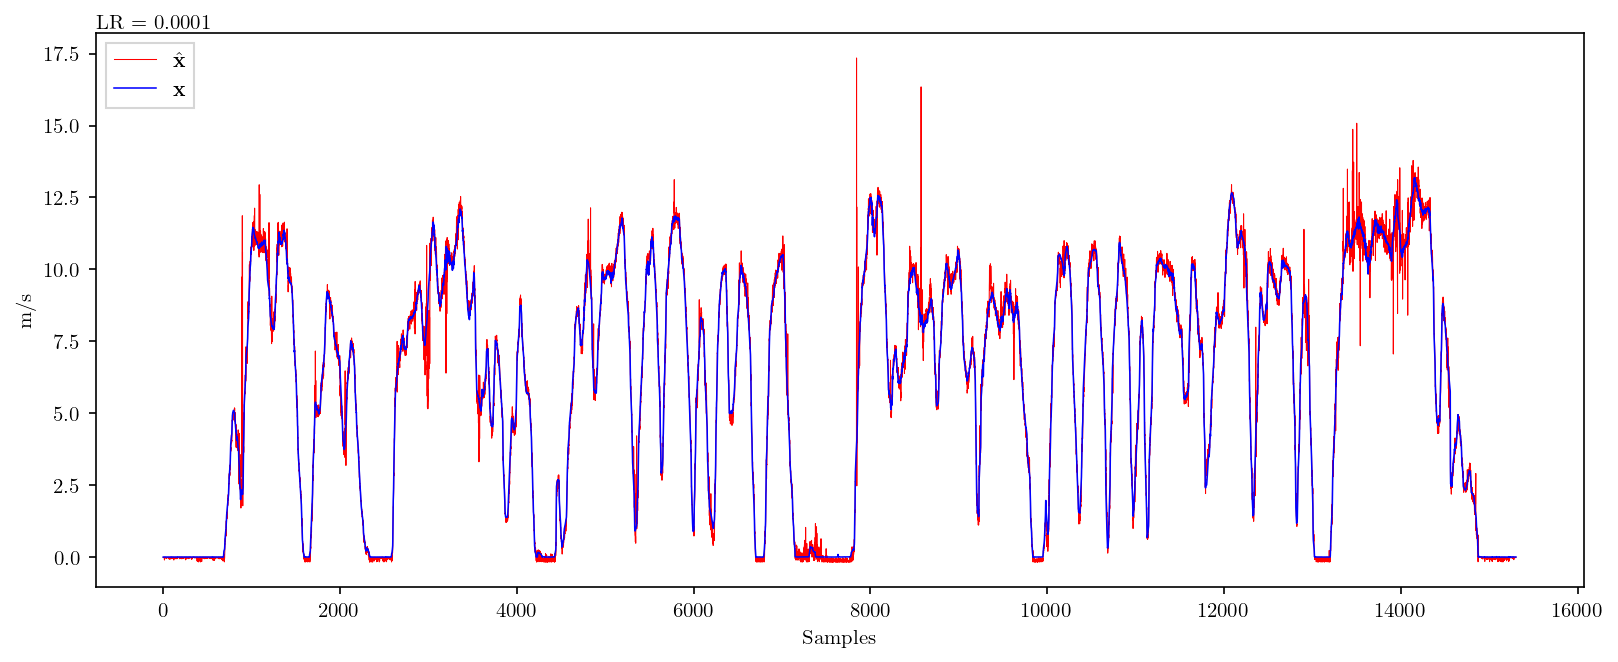

Inference time [ms]: 1.5153365143605995


In [51]:
path = 'checkpoints/' + tag + '/'
lr = pretrained['lr']
epoch = 9999
preview(model,valid_loader,device,path,epoch,lr,show=True,save=True)

In [52]:
min(losses['valid_losses'])*1e6

229.43689567173556